In [1]:
%matplotlib ipympl

from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import data_groups
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile

In [2]:
def p_excited(t, Omega, delta, tau):
    Omega_gen = np.sqrt(Omega**2 + delta**2)
    offset = Omega ** 2 / Omega_gen ** 2 / 2
    return offset + (Omega ** 2 / Omega_gen ** 2 * np.sin(Omega_gen * t / 2) ** 2 - offset) * np.exp(-t / tau)

span = 30e3*2*np.pi
def uniform_inhomogenous_broadening(delta):
    return np.heaviside(span - delta, 0.5) * np.heaviside(delta + span, 0.5) / (2 * span)
    
def p_excited_with_inhomogenous(t, a, Omega, tau, c):
    def integrand(delta):
        return p_excited(t, Omega, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c
    
def p_excited_with_inhomogenous_1(t, Omega, a, tau, c, scale_factor):
    def integrand(delta):
        return p_excited(t, Omega * scale_factor, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c

In [3]:
def gaussian(f, f_0, a, sigma, b, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages, p0=None):
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0})
    #fitter.set_bounds("a", -np.inf, 0)
    #fitter.set_bounds("c", 0, np.inf)
    #fitter.set_p0({"a": -1})
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.fit()
    
    return fitter

def gaussian0(f, f0, a, sigma): 
    return a * np.exp( -(f - f0) **2 / (2 * sigma ** 2) )

def four_peak_gaussian(f, f1, f2, f3, f4, a1, a2, a3, a4, sigma1, sigma2, sigma3, sigma4):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + gaussian0(f, f3, a3, sigma3) + gaussian0(f, f4, a4, sigma4) + c

def linear(x, a, b):
    return x * a + b

def voigt(f, f0, a, sigma, gamma, c):
    v = voigt_profile(f-f0, sigma, gamma)
    return a*v/(np.abs(np.max(v))) + c

def get_voigt_fit(detunings, voltages):
    fitter = Fitter(voigt)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f0": 0, "a": -0.16, "c": 1, "sigma": 0.6, "gamma": 0.2})
    fitter.fit()
    

    return fitter

In [4]:
xs = np.linspace(0, 100, 100)
ys = voigt(xs, 50, 1, 1, 1)

fig, ax = plt.subplots()
ax.plot(xs, ys)
plt.show()

TypeError: voigt() missing 1 required positional argument: 'c'

In [5]:
def rf_spectroscopy(data_list):
    antihole_heights = []
    antihole_height_errs = []
    rf_heights = []
    rf_height_errs = []
    offsets = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        offset = headers["params"]["rf"]["offset"].to("kHz").magnitude
        offsets.append(offset)
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        # fit heights
        antihole_fit = get_gaussian_fit(detunings, antihole_avg/chasm_avg, p0={"sigma": 0.3})
        antihole_heights.append(antihole_fit.results["a"])
        antihole_height_errs.append(antihole_fit.errors["a"])
        
        rf_fit = get_gaussian_fit(detunings, rf_avg/chasm_avg, p0={"sigma": 0.3})
        rf_heights.append(rf_fit.results["a"])
        rf_height_errs.append(rf_fit.errors["a"])

    offsets = np.array(offsets)
    antihole_heights = np.array(antihole_heights)
    antihole_height_errs = np.array(antihole_height_errs)
    rf_heights = np.array(rf_heights)
    rf_height_errs = np.array(rf_height_errs)
    ratios = rf_heights / antihole_heights
    ratio_errs = ratios * np.sqrt((rf_height_errs / rf_heights) ** 2 + (antihole_height_errs / antihole_heights) ** 2)

    xs = offsets
    ys = ratios
    return xs, ys
    

In [6]:
def rf_spectroscopy_field(data_list):
    positive_antihole_heights = []
    positive_antihole_height_errs = []
    negative_antihole_heights = []
    negative_antihole_height_errs = []
    positive_rf_heights = []
    positive_rf_height_errs = []
    negative_rf_heights = []
    negative_rf_height_errs = []
    offsets = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        offset = headers["params"]["rf"]["offset_2"].to("kHz").magnitude
        offsets.append(offset)
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        # fit heights
        positive_mask = detunings > 0
        positive_antihole_fit = get_gaussian_fit(detunings[positive_mask], antihole_avg[positive_mask]/chasm_avg[positive_mask], p0={"f_0": 2, "a": -0.1, "c": 1, "sigma": 0.3})
        positive_antihole_heights.append(positive_antihole_fit.results["a"])
        positive_antihole_height_errs.append(positive_antihole_fit.errors["a"])
        
        positive_rf_fit = get_gaussian_fit(detunings[positive_mask], rf_avg[positive_mask]/chasm_avg[positive_mask], p0={"f_0": 2, "a": -0.1, "c": 1, "sigma": 0.3})
        positive_rf_heights.append(positive_rf_fit.results["a"])
        positive_rf_height_errs.append(positive_rf_fit.errors["a"])
    
        negative_mask = detunings < 0
        negative_antihole_fit = get_gaussian_fit(detunings[negative_mask], antihole_avg[negative_mask]/chasm_avg[negative_mask], p0={"f_0": -2, "a": -0.1, "c": 1, "sigma": 0.3})
        negative_antihole_heights.append(negative_antihole_fit.results["a"])
        negative_antihole_height_errs.append(negative_antihole_fit.errors["a"])
        
        negative_rf_fit = get_gaussian_fit(detunings[negative_mask], rf_avg[negative_mask]/chasm_avg[negative_mask], p0={"f_0": -2, "a": -0.1, "c": 1, "sigma": 0.3})
        negative_rf_heights.append(negative_rf_fit.results["a"])
        negative_rf_height_errs.append(negative_rf_fit.errors["a"])

    offsets = np.array(offsets)
    positive_antihole_heights = np.array(positive_antihole_heights)
    positive_antihole_height_errs = np.array(positive_antihole_height_errs)
    negative_antihole_heights = np.array(negative_antihole_heights)
    negative_antihole_height_errs = np.array(negative_antihole_height_errs)
    positive_rf_heights = np.array(positive_rf_heights)
    positive_rf_height_errs = np.array(positive_rf_height_errs)
    negative_rf_heights = np.array(negative_rf_heights)
    negative_rf_height_errs = np.array(negative_rf_height_errs)
    positive_ratios = positive_rf_heights / positive_antihole_heights
    positive_ratio_errs = positive_ratios * np.sqrt((positive_rf_height_errs / positive_rf_heights) ** 2 + (positive_antihole_height_errs / positive_antihole_heights) ** 2)
    negative_ratios = negative_rf_heights / negative_antihole_heights
    negative_ratio_errs = negative_ratios * np.sqrt((negative_rf_height_errs / negative_rf_heights) ** 2 + (negative_antihole_height_errs / negative_antihole_heights) ** 2)

    xs = offsets
    positive_ys = positive_ratios
    negative_ys = negative_ratios
    return xs, positive_ys, negative_ys
    

In [7]:
def rf_flopping(data_list):
    antihole_heights = []
    antihole_height_errs = []
    rf_heights = []
    rf_height_errs = []
    times = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        times.append(headers["params"]["rf"]["duration"].to("ms").magnitude)
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        # fit heights
        antihole_fit = get_gaussian_fit(detunings, antihole_avg/monitor_antihole_avg, p0={"sigma": 0.5})
        # antihole_fit = get_voigt_fit(detunings, antihole_avg/chasm_avg)
        antihole_heights.append(antihole_fit.results["a"])
        antihole_height_errs.append(antihole_fit.errors["a"])

        # REMOVE:
        # antihole_line = antihole_avg/chasm_avg
        # antihole_heights.append(np.abs(np.max(antihole_line) - np.min(antihole_line)))

        
        rf_fit = get_gaussian_fit(detunings, rf_avg/monitor_rf_avg, p0={"sigma": 0.5})
        # rf_fit = get_voigt_fit(detunings, rf_avg/chasm_avg)
        rf_heights.append(rf_fit.results["a"])
        rf_height_errs.append(rf_fit.errors["a"])

        # REMOVE:
        # rf_line = rf_avg/chasm_avg
        # rf_heights.append(np.abs(np.max(rf_line) - np.min(rf_line)))
    
    times = np.array(times)
    antihole_heights = np.array(antihole_heights)
    antihole_height_errs = np.array(antihole_height_errs)
    rf_heights = np.array(rf_heights)
    rf_height_errs = np.array(rf_height_errs)
    ratios = rf_heights / antihole_heights
    ratio_errs = ratios * np.sqrt((rf_height_errs / rf_heights) ** 2 + (antihole_height_errs / antihole_heights) ** 2)


    

    xs = times
    ys = ratios
    return xs, ys
    

In [8]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

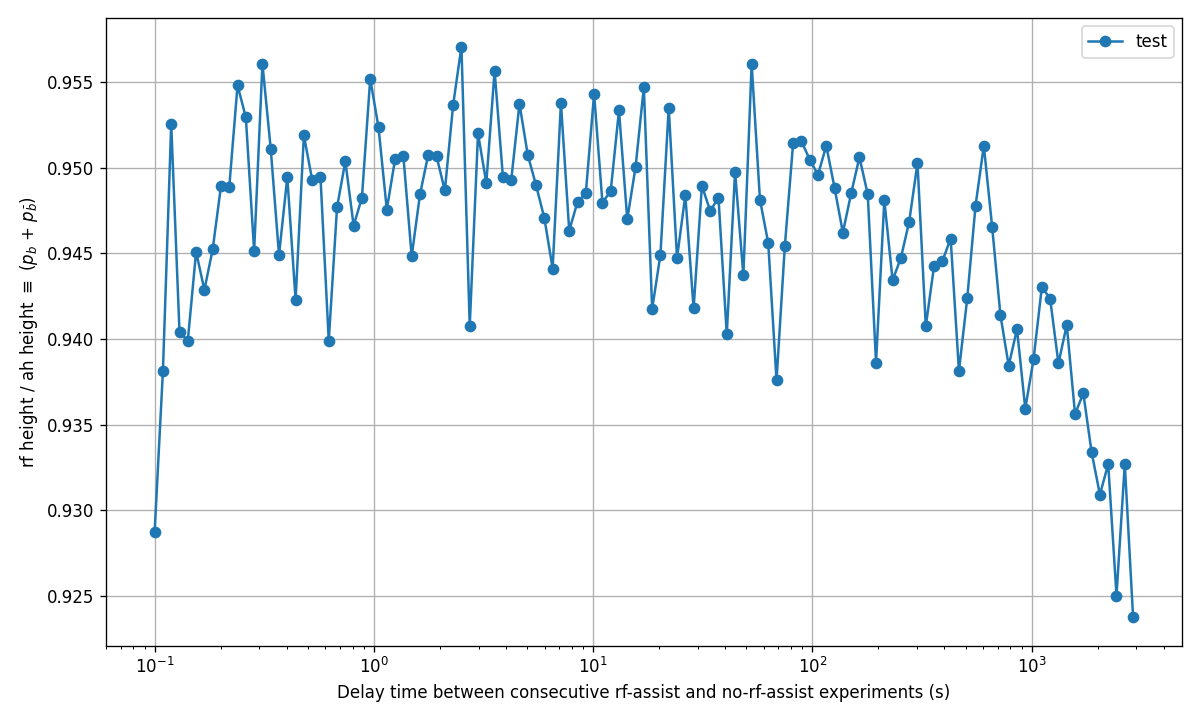

In [9]:
data = {
    #"0.3 s antihole": (54862, 54961),
    #"0.03 s antihole": (54962, 55061),
    #"0.3 s antihole 1": (55094, 55103),
    #"0.03 s antihole 1": (55104, 55113),
    #"0.03 s antihole 2": (55114, 55123),
    #"0.3 s antihole 2": (55124, 55133),
    #"1 s antihole, -46 kHz, 3": (55134, 55143),
    #"0.03 s antihole, 100 kHz, 3": (55144, 55153),
    #"1 s antihole, -46 kHz 4": (55154, 55163),
    #"0.03 s antihole, 100 kHz, 4": (55164, 55173),
    #"1 s antihole, -46 kHz 5": (55174, 55183),
    #"0.03 s antihole, 100 kHz, 5": (55184, 55193),
    #"1 s antihole, -46 kHz 6": (55194, 55203),
    #"0.03 s antihole, -46 kHz, 6": (55204, 55213),
    
    # "1 s antihole, -46 kHz 7": (55214, 55223),
    # "0.03 s antihole, -46 kHz, 7": (55224, 55233),
    # "0.03 s antihole, -46 kHz, 8": (55234, 55243),
    # "1 s antihole, -46 kHz, 9": (55273, 55282),
    # "0.03 s antihole, -46 kHz, 1.94 s wait, 9": (55283, 55292),
    # "1 s antihole, -46 kHz, 10": (55293, 55302),
    # "0.03 s antihole, -46 kHz, 10": (55303, 55312),
    # "1 s antihole, -46 kHz, 10 s wait, 11": (55313, 55322),
    # "0.03 s antihole, -46 kHz, 10 s wait, 11": (55323, 55332),
    # "1 s antihole, -46 kHz, wide scan, 12": (55333, 55342),

    # "0.03 s antihole -46 kHz": (55940, 55949),
    # "1 s antihole -46 kHz": (55950, 55959),

    # temperature dependence
    # "": (56674, 56863),

    "test": [kk for kk in range(73794, 74033) if kk % 2 == 1],
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)

temps = {
    56689 : 7.4,
    56699 : 8.2,
    56719 : 9.5,
    56749 : 11,
    56759 : 11.6,
    56779 : 12.8,
    56799 : 14.1,
    56809 : 13.2,
    56829 : 4.5,
}

delay_times = np.logspace(-1, 3.5, 120)

for label, identification in data.items():
    data_list = data_identification_to_list(identification)
    data_indices = []
    heights = []
    
    for kk in data_list:
        xs, ys = rf_flopping([kk])
        data_indices.append(kk - data_list[0])
        heights.append(ys[0])
        if kk in temps:
            # ax.plot([kk - data_list[0]]*2, [0.9*ys[0], 1.1*ys[0]], '-', color="C1")
            ax.text(kk - data_list[0], 0.95*ys[0], f"{temps[kk]:.1f} K", color="C1")
    ax.semilogx(delay_times[:len(heights)], heights, 'o-', label = label)
    
ax.set_xlabel("Delay time between consecutive rf-assist and no-rf-assist experiments (s)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
    
plt.tight_layout()
plt.grid()
plt.show()

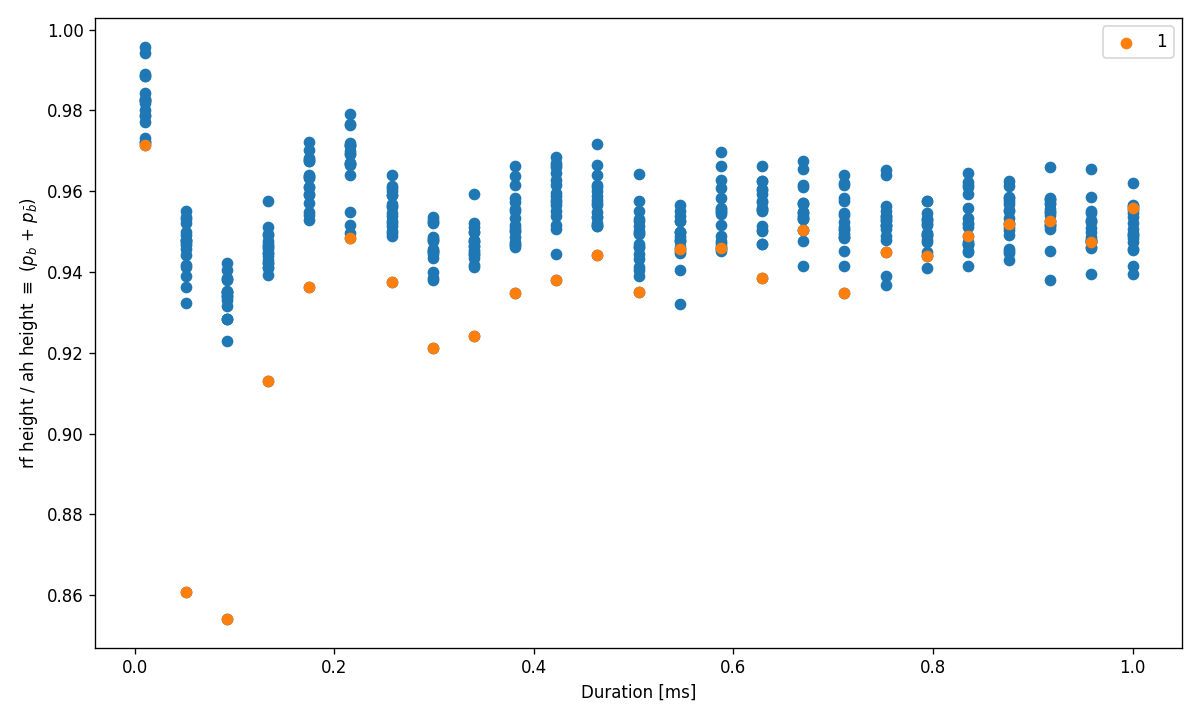

In [124]:
data = {
    # "abar->bbar, 0.1 s antihole": (54548, 54557),
    #"abar->bbar, 0.3 s antihole": (54558, 54567),
    # "abar->bbar, 0.03 s antihole": (54568, 54577),
    #"abar->bbar, 1 s antihole": (54578, 54587),
    #"abar->bbar, 3 s antihole": (54588, 54597),
    # "abar->bbar, one repeat, 0.03 s antihole": [54800 + kk * 3 for kk in range(10)],
    # "abar->bbar, one repeat, 0.1 s antihole": [54801 + kk * 3 for kk in range(10)],
    # "abar->bbar, one repeat, 0.3 s antihole": [54802 + kk * 3 for kk in range(10)],
    #"abar->bbar, 0.1 s antihole 2": [54598, 54607],
    #"abar->bbar, 0.1 s antihole reverse order": [54608, 54617],
    #"abar->bbar, 0.1 s antihole rf assist 1": [54618, 54627],
    #"abar->bbar, 0.1 s antihole rf assist 2": [54628, 54637],
    #"abar->bbar, 0.1 s antihole rf assist 3": [54638, 54647],

    "": (56981 , 57436),
    "1": (56981 , 56981+24),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)

for label, identification in data.items():
    data_list = data_identification_to_list(identification)
    xs, ys = rf_flopping(data_list)
    ax.scatter(xs, ys, label = label)
    
ax.set_xlabel("Duration [ms]")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
    
plt.tight_layout()
plt.show()

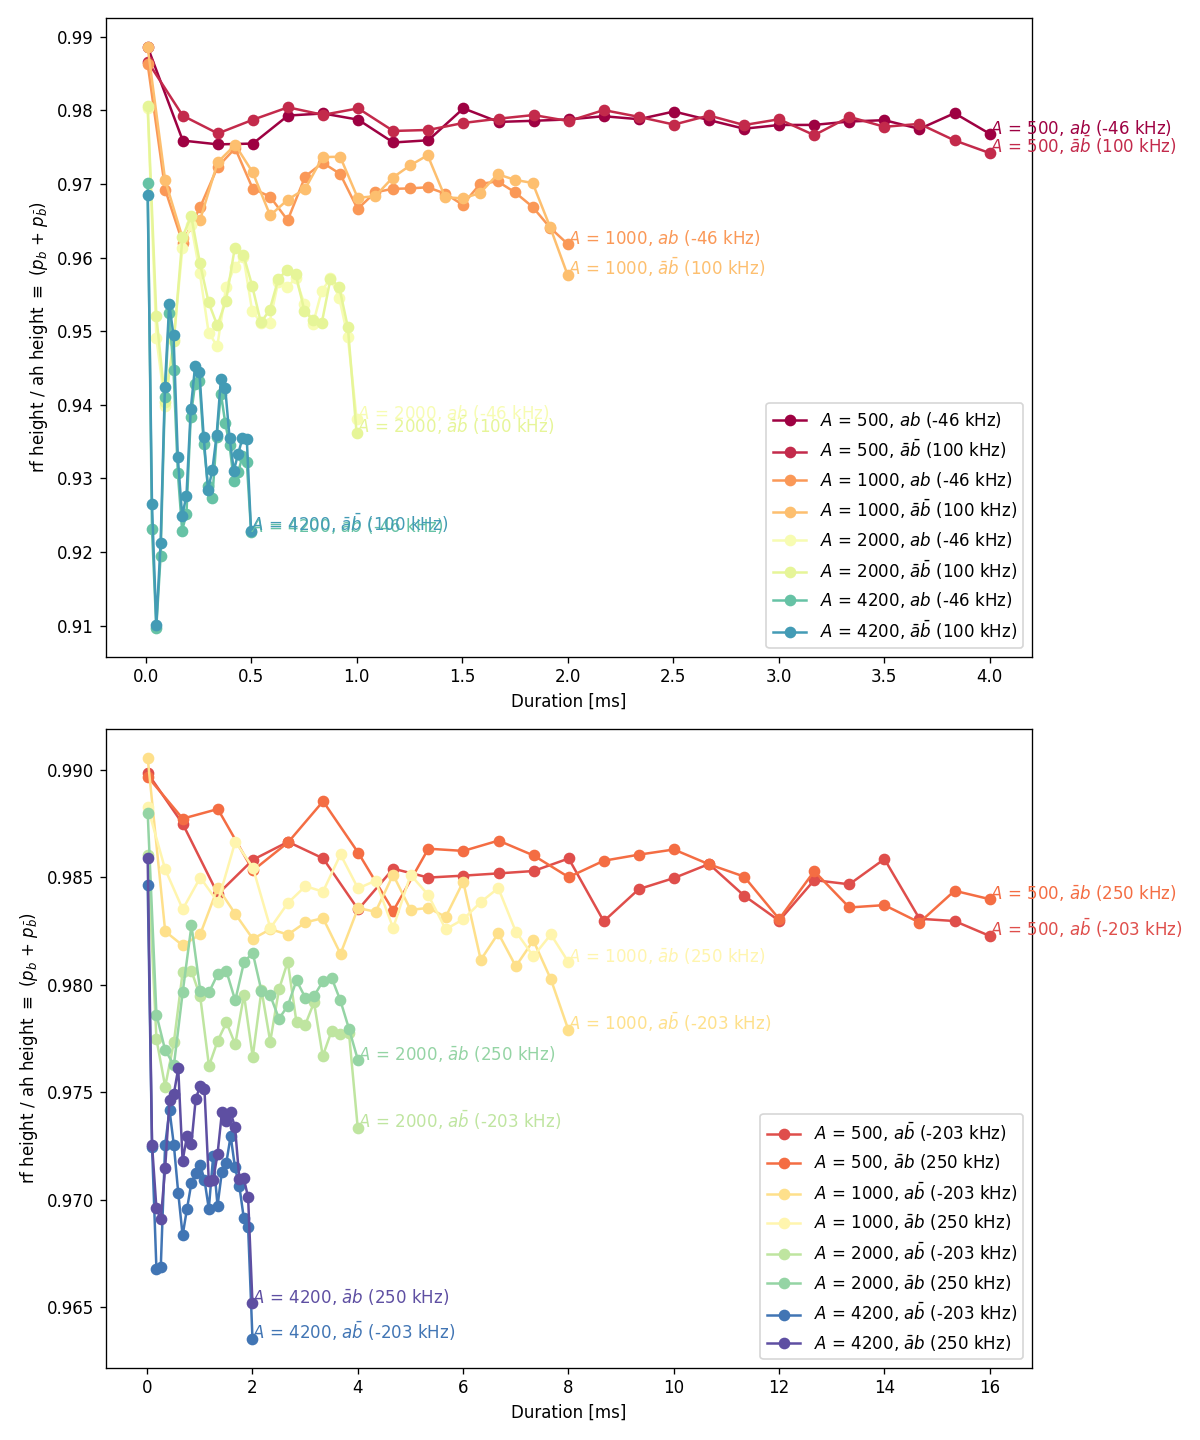

In [125]:
rf_amplitudes = [500, 1000, 2000, 4200]
rf_offsets = np.array([-46, 100, -203, 250])
rf_offset_labs = [r"$ab$", r"$\bar{a}\bar{b}$", r"$a\bar{b}$", r"$\bar{a}b$"]

all_data = [52547, 54546]
num_per_set = 25

cmap = colormaps.get_cmap('Spectral')
colors = cmap(np.linspace(0, 1, (all_data[1] - all_data[0]+1) // num_per_set // 5))

data = {}
counter = all_data[0]

for kk in range(len(rf_amplitudes)):
    for ll in range(len(rf_offsets)):
        data[fr"$A$ = {rf_amplitudes[kk]}, {rf_offset_labs[ll]} ({rf_offsets[ll]} kHz)"] = [counter, counter + num_per_set - 1]
        counter += num_per_set

fig, axs = plt.subplots(2, 1, figsize = (10, 12), dpi = 120)

for kk, (label, data_range) in enumerate(data.items()):
    data_list = range(data_range[0], data_range[1]+1)
    xs, ys = rf_flopping(data_list)
    if "$ab$" in label or r"$\bar{a}\bar{b}$" in label:
        ax = 0
    else:
        ax = 1
    axs[ax].plot(xs, ys, 'o-', color = colors[kk], label = label)
    axs[ax].text(xs[0], ys[0], label, color = colors[kk])
    

for ax in axs:
    ax.set_xlabel("Duration [ms]")
    ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
    ax.legend()
    
plt.tight_layout()
plt.show()

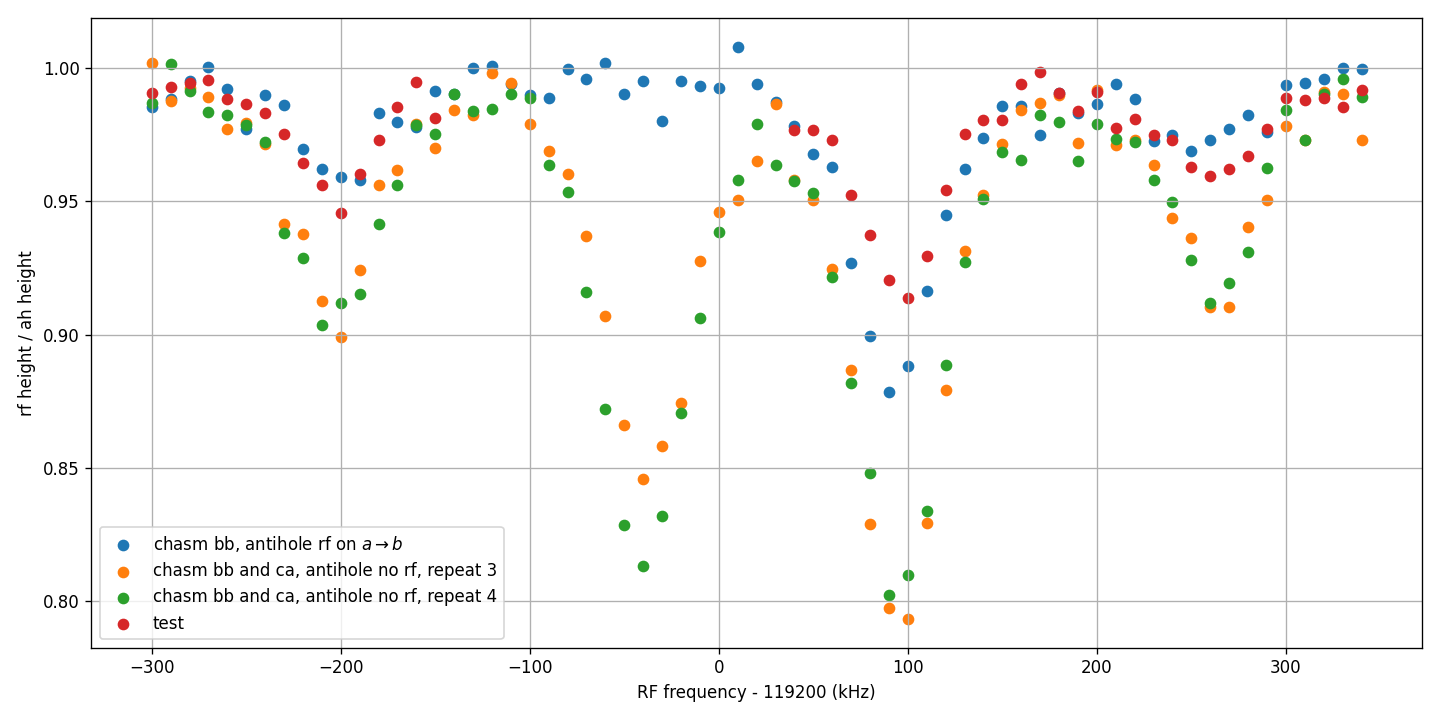

In [30]:
# data_list = range(3599, 3718)

data = {
    # "no rf": (55402, 55433),
    # "half rf, 5 ms": (55434, 55465),
    # "full rf, 5 ms": (55530, 55561),
    # "less than half rf, 5 ms": (55562, 55593),
    # "full rf and then ah, 5 ms": (55724, 55755),
    # "full rf and then chasm, ah, 5 ms": (55756, 55787),
    # "full rf, 3 s wait, and then chasm, ah, 5 ms": (55788, 55819),
    # "no rf, 3 s wait, and then chasm, ah, 5 ms": (55820, 55851),
    # "half rf, 20 ms": (55907, 55938),

    #####
    # "full rf, 3 s wait, and then chasm, ah, 5 ms (replicated)": (56120, 56151),
    # "full rf, 10 s wait, and then chasm, ah, 5 ms": (56152, 56183),
    # "full rf, 3 s wait, and then chasm, ah, 5 ms, scan cross transitions": (56185, 56217),
    # "full rf, 3 s wait, and then chasm, 1s ah, 5 ms": (56218, 56249),
    # "no rf (13.5 K)": (56255, 56286), # can't fit due to antihole broadening
    # "no rf (4 K, after turning off pt to 15 K)": (56287, 56318),
    # "no rf again": (56319, 56350),
    # "no rf again 2": (56351, 56382),

    
    # "no rf assist, detect ac": (56383, 56414),
    # "no rf assist, detect bb": (56415, 56446),
    # "no rf assist, detect ca": (56447, 56478),
    
    # "rf assist, detect ac": (56479, 56510),
    # "rf assist, detect bb": (56511, 56542),
    # "rf assist, detect ca": (56543, 56574),
    
    # "no rf assist, detect ac, after 15K heat + 4K recool": (56575, 56606),
    # "no rf assist, detect bb, after 15K heat + 4K recool": (56607, 56638),
    # "no rf assist, detect ca, after 15K heat + 4K recool": (56639, 56670),

    

    # "no rf, detect ac, much after recool after probing 100 kHz many times": (56880, 56911),

    # "no rf, no detect eo": (56912, 56943),
    


    
    # "chasm rf assist, no antihole rf assist, detect bb": (57769, 57800),
    # "no chasm rf assist, no antihole rf assist, detect bb": (57833, 57864),
    # "chasm rf assist, no antihole rf assist, detect bb, after 15K heat + 4K recool": (57865, 57896),
    # "no chasm rf assist, no antihole rf assist, detect bb, after 15K heat + 4K recool": (57907, 57938),
    # "no chasm rf assist, no antihole rf assist, detect bb, immediately after the previous one": (57939, 57970),
    # "no chasm rf assist, no antihole rf assist, detect bb, immediately after the previous one again": (57971, 58002),
    # "no chasm rf assist, no antihole rf assist, detect bb, immediately after the previous one again 2": (58003, 58034),
    # "chasm rf assist, half antihole rf assist, detect bb": (58035, 58066),
    # "chasm rf assist, no antihole rf assist, detect bb again": (58067, 58098),





    # antihole on ac, bb
    # "no rf, chasm ca, detect bb": (72469, 72500),
    # "no rf assist, chasm ca, detect bb, 4 K": (72501, 72532),
    # "no rf assist, chasm ca, detect bb, warm-recool": (72533, 72564),
    # "no rf assist, chasm ca, detect ac, 4 K": (72565, 72596),
    # "no rf assist, chasm ca, detect ac, warm-recool": (72597, 72628),
    # "no rfa, chasm ac, detect ac, 4 K": (),
    # "no rfa, chasm ac, detect ac, warm-recool": (),


    # "a bbar rf assist -300 -125": (72629, 72660),
    # "a bbar rf assist -220 -190": (72661, 72692),
    # "a bbar rf assist -300 -125 again": (72693, 72724),
    # "a bbar rf assist -220 -190, 4200": (72725, 72756),
    # "a bbar rf assist -220 -190, 4200 20": (72757, 72788),
    # "a bbar rf assist -220 -190, 2000": (72789, 72803),
    #"no rf assist": (72851, 72915),
    #"a bbar rf assist": (72916, 72980),
    # "abar b rf assist": (72981, 73045),
    # "abar b rf assist 1": (73046, 73110),
    # "abar b rf assist 2": (73111, 73175),
    # "a b rf assist": (73176, 73240),
    # "a b rf assist @ 100 kHz": (73241, 73305),
    #"ab abarbbar rf assist": (73306, 73370),
    #"ab abarbbar rf assist before antihole": (73371, 73435),
    #"ab abarbbar rf assist ONCE before antihole ": (73436, 73500),
    #"no rf assist 2": (73533, 73597),
    #"no rf assist 3": (73598, 73662),
    #"no rf assist 4": (73663, 73727),
    #"no rf assist after 5 runs of rf assist pulse only": (73728, 73792),

    #"chasm bb and ca, antihole no rf, after hours of hole/antihole relaxation": (74034, 74098),
    #"chasm bb and ca, antihole no rf, repeat 1": (74099, 74163),
    #"chasm bb and ca, antihole no rf , repeat 2": (74164, 74228),
    #"chasm bb and ac, antihole no rf": (74229, 74293),
    #"chasm bb and ac, antihole no rf, repeat 1": (74294, 74358),
    #"chasm bb and ac, antihole rf on $a\\to b$": (74359, 74423),
    #"chasm bb, antihole no rf": (74424, 74488),
    "chasm bb, antihole rf on $a\\to b$": (74489, 74553),
    #"chasm bb, antihole rf on $a\\to b$, repeat 1": (74554, 74618),
    "chasm bb and ca, antihole no rf, repeat 3": (74619, 74683),
    "chasm bb and ca, antihole no rf, repeat 4": (74684, 74748),
    #"chasm bb and ca, antihole rf on $a\\to b$": (74749, 74813),
    #"chasm bb and ac, antihole no rf, after hours of hole/antihole relaxation": (74814, 74878),
    #"chasm bb and ac, antihole no rf, repeat 2": (74879, 74943),
    #"chasm bb and ca, antihole no rf, repeat 5": (74944, 75008),
    #"chasm bb rf, antihole no rf": (75009, 75073),
    "test": (80916, 80962),
}
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
markers = ['o', 'x', '*']
for ll, (label, data_range) in enumerate(data.items()):
    data_list = range(data_range[0], data_range[1]+1)
    xs, ys = rf_spectroscopy(data_list)
    marker = markers[ll//10]
    ax.scatter(xs, ys, label=label, marker=marker)#, color=f"C{ll%3}", marker=markers[ll//3])
    
ax.set_xlabel("RF frequency - 119200 (kHz)")
ax.set_ylabel("rf height / ah height")# $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [ ]:
data = {
    #"" : [79939, 79952],
    # "": [80008, 80095],
    "250": [80120, 80455],
    "450": [80456, 80791],
    "650": [98711, 98792],
}

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)



for label, data_range in data.items():
    data_list = range(data_range[0], data_range[1]+1)
    # xs, pos_ys, neg_ys = rf_spectroscopy_field(data_list)

    all_xs, all_pos_ys, all_neg_ys = rf_spectroscopy_field(data_list)

    xs = []
    pos_ys = []
    neg_ys = []
    
    for rf_offset in set(all_xs):
        mask = all_xs == rf_offset
        xs.append(rf_offset)
        pos_ys.append(np.average(all_pos_ys[mask]))
        neg_ys.append(np.average(all_neg_ys[mask]))

    xs = np.array(xs)
    pos_ys = np.array(pos_ys)
    neg_ys = np.array(neg_ys)
    
    ax.scatter(xs, pos_ys, label = label + " $\\mathcal{N}=+1$")
    ax.scatter(xs, neg_ys, label = label + " $\\mathcal{N}=-1$")

    mask = xs < -150
    pos_fitter = get_gaussian_fit(xs[mask], pos_ys[mask], p0={"f_0": -209})
    pos_fitter.set_bounds("b", -1e-12, 1e-12)
    pos_fitter.set_p0({"b": 0})
    pos_fitter.fit()
    neg_fitter = get_gaussian_fit(xs[mask], neg_ys[mask], p0={"f_0": -209})
    neg_fitter.set_bounds("b", -1e-12, 1e-12)
    neg_fitter.set_p0({"b": 0})
    neg_fitter.fit()
    xs_plt = np.linspace(min(xs[mask]), max(xs[mask]), 100)
    ax.plot(xs_plt, pos_fitter.fitted_value(xs_plt), color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.01, pos_fitter.all_results_str().split("\n")[0] + " kHz", color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.005, pos_fitter.all_results_str().split("\n")[2] + " kHz", color="C0")
    ax.plot(xs_plt, neg_fitter.fitted_value(xs_plt), color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.01, neg_fitter.all_results_str().split("\n")[0] + " kHz", color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.005, neg_fitter.all_results_str().split("\n")[2] + " kHz", color="C1")
    
    mask = abs(xs) < 150
    pos_fitter = get_gaussian_fit(xs[mask], pos_ys[mask], p0={"f_0": np.average(xs[mask]), "sigma": 2})
    # pos_fitter.set_bounds("b", -1e-12, 1e-12)
    pos_fitter.set_p0({"b": 0})
    pos_fitter.fit()
    neg_fitter = get_gaussian_fit(xs[mask], neg_ys[mask], p0={"f_0": np.average(xs[mask]), "sigma": 2})
    # neg_fitter.set_bounds("b", -1e-12, 1e-12)
    neg_fitter.set_p0({"b": 0})
    neg_fitter.fit()
    xs_plt = np.linspace(min(xs[mask]), max(xs[mask]), 100)
    ax.plot(xs_plt, pos_fitter.fitted_value(xs_plt), color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.01, pos_fitter.all_results_str().split("\n")[0] + " kHz", color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.005, pos_fitter.all_results_str().split("\n")[2] + " kHz", color="C0")
    ax.plot(xs_plt, neg_fitter.fitted_value(xs_plt), color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.01, neg_fitter.all_results_str().split("\n")[0] + " kHz", color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.005, neg_fitter.all_results_str().split("\n")[2] + " kHz", color="C1")
    
    mask = xs > 200
    pos_fitter = get_gaussian_fit(xs[mask], pos_ys[mask], p0={"f_0": 258, "sigma": 2, "c": 0.9})
    # pos_fitter.set_bounds("b", -1e-12, 1e-12)
    pos_fitter.set_p0({"b": 0})
    pos_fitter.fit()
    neg_fitter = get_gaussian_fit(xs[mask], neg_ys[mask], p0={"f_0": 258, "sigma": 2, "c": 0.9})
    # neg_fitter.set_bounds("b", -1e-12, 1e-12)
    neg_fitter.set_p0({"b": 0})
    neg_fitter.fit()
    xs_plt = np.linspace(min(xs[mask]), max(xs[mask]), 100)
    ax.plot(xs_plt, pos_fitter.fitted_value(xs_plt), color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.01, pos_fitter.all_results_str().split("\n")[0] + " kHz", color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.005, pos_fitter.all_results_str().split("\n")[2] + " kHz", color="C0")
    ax.plot(xs_plt, neg_fitter.fitted_value(xs_plt), color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.01, neg_fitter.all_results_str().split("\n")[0] + " kHz", color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.005, neg_fitter.all_results_str().split("\n")[2] + " kHz", color="C1")

ax.set_xlabel("RF frequency - 119200 (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

In [130]:
data, headers = get_experiment_data(90804)

In [106]:
(chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)
detunings_MHz = headers["detunings"].to("MHz").magnitude

IndexError: invalid index to scalar variable.

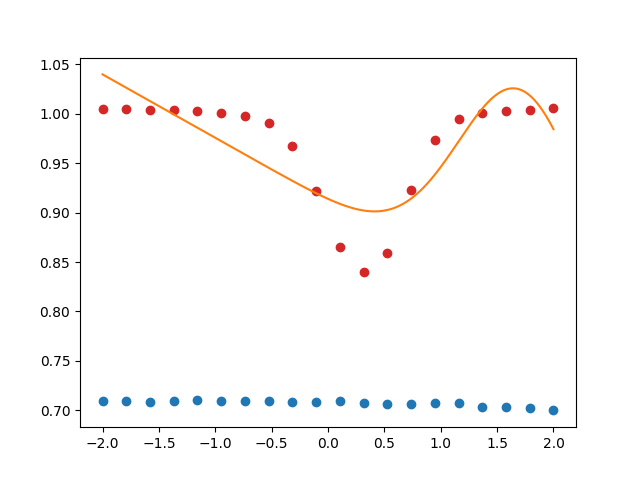

In [118]:
plt_monitor = False
use_positive = None

antihole_normalized = antihole_avg/monitor_antihole_avg
#antihole_normalized = antihole_avg/monitor_antihole_avg
rf_normalized = rf_avg/monitor_rf_avg
#rf_normalized = rf_avg/monitor_rf_avg


if use_positive == True:
    mask = detunings_MHz > 0
elif use_positive == False:
    mask = detunings_MHz < 0
else:
    mask = detunings_MHz < 1e13

fig, ax = plt.subplots()
ax.scatter(detunings_MHz, chasm_avg, label="chasm", color="C0")
#ax.scatter(detunings_MHz, antihole_avg, label="antihole", color="C1")
#ax.scatter(detunings_MHz, monitor_antihole_avg, label="antihole monitor", color="C2")
#ax.scatter(detunings_MHz, rf_avg, label="rf", color="C2")

#ax.scatter(detunings_MHz, antihole_normalized, label="antihole / monitor", color="C1")
ax.scatter(detunings_MHz[mask], antihole_avg[mask]/chasm_avg[mask], label="antihole / chasm", color="C3")
antihole_fit = get_gaussian_fit(detunings_MHz[mask], antihole_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings_MHz[mask]) + 0.001})
xaxis = np.linspace(min(detunings_MHz[mask]), max(detunings_MHz[mask]), 1000)
ax.plot(xaxis, antihole_fit.fitted_value(xaxis), label = "antihole fit", color="C1")

if "rf_repeats" in headers["params"]["detect"]:
    #ax.scatter(detunings_MHz, rf_normalized / 5.7, label="rf / monitor", color="C2")
    ax.scatter(detunings_MHz[mask], rf_avg[mask]/chasm_avg[mask], label="rf / chasm", color="C4")
    #ax.scatter(detunings_MHz[mask], rf_avg[mask]/antihole_avg[mask], label="rf / antihole")
    #ax.scatter(detunings_MHz, monitor_rf_avg, label="rf monitor", color="C3")
    #ax.scatter(detunings_MHz, rf_avg, label="rf avg", color="C4")
    # rf_fit = get_gaussian_fit(detunings_MHz[mask], rf_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings_MHz[mask]) + 0.001})
    # ax.plot(xaxis, rf_fit.fitted_value(xaxis), label = 'rf fit', color="C2")
    pass
            
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Normalized transmission")
plt.legend()
plt.tight_layout()
plt.show()

print(antihole_fit.all_results_str())
print()
#print(rf_fit.all_results_str())

/tmp/ipykernel_25590/1137749572.py:31: RuntimeWarning: invalid value encountered in divide
  return a*v/(np.abs(np.max(v))) + c


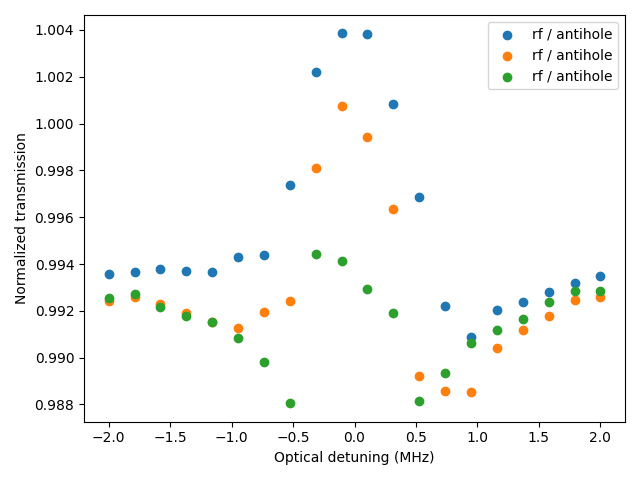

f0 = 0.011(3)
a = -0.1080(13)
sigma = 0.259(13)
gamma = 0.06(2)
c = 1.0422(6)
Reduced chi-square is undefined.

f0 = 0.016(4)
a = -0.1082(16)
sigma = 0.214(18)
gamma = 0.16(3)
c = 1.0372(8)
Reduced chi-square is undefined.


In [90]:
datas = [55399, 55400, 55401]

fig, ax = plt.subplots()

for kk in datas:
    data, headers = get_experiment_data(kk)
    (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)
    detunings_MHz = headers["detunings"].to("MHz").magnitude
    plt_monitor = False
    use_positive = None

    chasm_normalized = chasm_avg / monitor_chasm_avg
    antihole_normalized = antihole_avg/monitor_antihole_avg
    #antihole_normalized = antihole_avg/monitor_antihole_avg
    rf_normalized = rf_avg/monitor_antihole_avg
    #rf_normalized = rf_avg/monitor_rf_avg
    
    
    if use_positive == True:
        mask = detunings_MHz > 0
    elif use_positive == False:
        mask = detunings_MHz < 0
    else:
        mask = detunings_MHz < 1e13
    #ax.scatter(detunings_MHz, chasm_avg / monitor_chasm_avg, label="chasm", color="C0")
    #ax.scatter(detunings_MHz, antihole_avg, label="antihole", color="C1")
    #ax.scatter(detunings_MHz, monitor_antihole_avg, label="antihole monitor", color="C2")
    #ax.scatter(detunings_MHz, rf_avg, label="rf", color="C2")
    
    #ax.scatter(detunings_MHz, antihole_normalized, label="antihole / monitor", color="C1")
    #ax.scatter(detunings_MHz[mask], antihole_avg[mask]/chasm_avg[mask], label="antihole / chasm")
    antihole_fit_v = get_voigt_fit(detunings_MHz[mask], antihole_avg[mask]/chasm_avg[mask])
    antihole_fit_g = get_gaussian_fit(detunings_MHz[mask], antihole_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings_MHz[mask]) + 0.001})
    xaxis = np.linspace(min(detunings_MHz[mask]), max(detunings_MHz[mask]), 1000)
    #ax.plot(xaxis, antihole_fit_v.fitted_value(xaxis), label = "antihole fit v")
    #ax.plot(xaxis, antihole_fit_g.fitted_value(xaxis), label = "antihole fit g")
    
    if "rf_repeats" in headers["params"]["detect"]:
        #ax.scatter(detunings_MHz, rf_normalized, label="rf / monitor", color="C2")
        #ax.scatter(detunings_MHz[mask], rf_avg[mask]/chasm_avg[mask], label="rf / chasm")
        ax.scatter(detunings_MHz[mask], rf_avg[mask]/monitor_rf_avg[mask]/(antihole_avg[mask]/monitor_antihole_avg[mask]), label="rf / antihole")
        #ax.scatter(detunings_MHz[mask], rf_avg[mask]/(antihole_avg[mask]), label="rf / antihole")
        #ax.scatter(detunings_MHz, monitor_rf_avg, label="rf monitor", color="C3")
        #ax.scatter(detunings_MHz, rf_avg, label="rf avg", color="C4")
        rf_fit_v = get_voigt_fit(detunings_MHz[mask], rf_avg[mask]/chasm_avg[mask])
        rf_fit_g = get_gaussian_fit(detunings_MHz[mask], rf_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings_MHz[mask]) + 0.001})
        #ax.plot(xaxis, rf_fit_v.fitted_value(xaxis), label = 'rf fit v')
        #ax.plot(xaxis, rf_fit_g.fitted_value(xaxis), label = 'rf fit g')
        pass
                
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Normalized transmission")
plt.legend()
plt.tight_layout()
plt.show()

print(antihole_fit_v.all_results_str())
print()
print(rf_fit_v.all_results_str())

In [1249]:
def temporal_drift(data_list, use_monitor=True, use_positive=None):
    chasm_voltages = []
    antihole_offsets = []
    antihole_amplitudes = []
    antihole_f0s = []
    antihole_slopes = []
    antihole_gammas = []
    rf_offsets = []
    rf_amplitudes = []
    rf_f0s = []
    rf_slopes = []
    rf_gammas = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        if use_positive == True:
            mask = detunings > 0
        elif use_positive == False:
            mask = detunings < 0
        else:
            mask = detunings < 1e13
        chasm_voltages.append(np.average(chasm_avg))
        if use_monitor:
            antihole_fit = get_gaussian_fit(detunings[mask], antihole_avg[mask]/monitor_antihole_avg[mask], p0={"f_0": np.average(detunings[mask])})
        else:
            antihole_fit = get_gaussian_fit(detunings[mask], antihole_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings[mask])})
        antihole_amplitudes.append(antihole_fit.results["a"])
        #antihole_slopes.append(antihole_fit.results["b"])
        antihole_offsets.append(antihole_fit.results["c"])
        antihole_gammas.append(antihole_fit.results["sigma"])
        antihole_f0s.append(antihole_fit.results["f_0"])
        
        if use_monitor:
            rf_fit = get_gaussian_fit(detunings[mask], rf_avg[mask]/monitor_rf_avg[mask], p0={"f_0": np.average(detunings[mask])})
        else:
            rf_fit = get_gaussian_fit(detunings[mask], rf_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings[mask])})
        rf_amplitudes.append(rf_fit.results["a"])
        #rf_slopes.append(rf_fit.results["b"])
        rf_offsets.append(rf_fit.results["c"])
        rf_gammas.append(rf_fit.results["sigma"])
        rf_f0s.append(rf_fit.results["f_0"])

    return (
        np.array(chasm_voltages),
        np.array(antihole_offsets),
        np.array(antihole_amplitudes),
        np.array(antihole_f0s),
        np.array(antihole_slopes),
        np.array(antihole_gammas),
        np.array(rf_offsets),
        np.array(rf_amplitudes),
        np.array(rf_f0s),
        np.array(rf_slopes),
        np.array(rf_gammas),
    )

In [644]:
data_numbers = np.array(list(range(25136, 26222)))  # no field plate
data_numbers = np.array(list(range(26265, 27203)))  # field plate
data_numbers = np.array(list(range(27204, 27446)))  # field plate reversed Stark shift

a = -0.000005(3)
b = 0.9891(5)
Reduced chi-square is undefined.
f0 = 0.9885(2)
a = 30.4(1.7)
sigma = 0.0036(2)
Reduced chi-square is undefined.
a = -0.000006(4)
b = 0.9893(5)
Reduced chi-square is undefined.
f0 = 0.98883(19)
a = 27.7(1.2)
sigma = -0.00382(19)
Reduced chi-square is undefined.


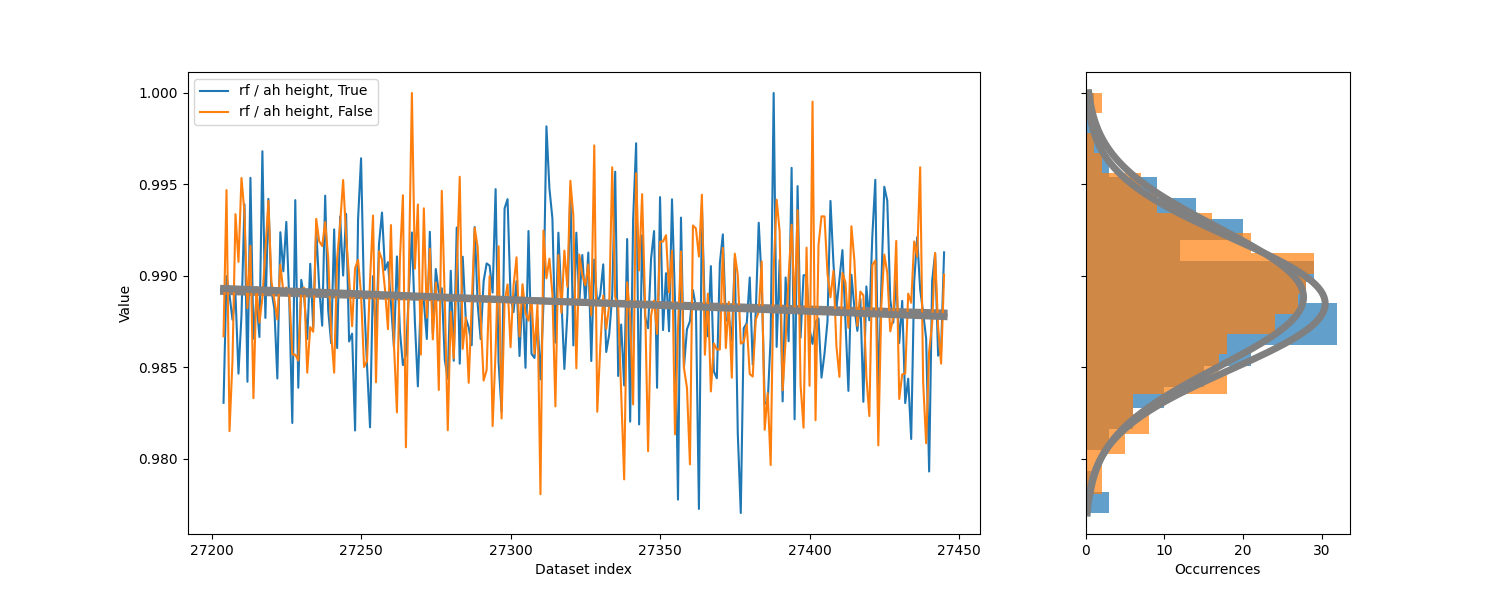

In [645]:
fig, axs = plt.subplots(1, 2, width_ratios=[3, 1], figsize=(15, 6), sharey=True)

ys = {}
xs = {}
for polarity in [True, False]:

    chasm_voltages, antihole_offsets, antihole_amplitudes, antihole_f0s, antihole_slopes, antihole_gammas, rf_offsets, rf_amplitudes, rf_f0s, rf_slopes, rf_gammas = temporal_drift(
        data_numbers, use_monitor=False, use_positive=polarity
    )
    rf_ah_height_ratio = rf_amplitudes / antihole_amplitudes / max(rf_amplitudes / antihole_amplitudes)
    axs[0].plot(data_numbers, rf_ah_height_ratio, label=f"rf / ah height, {polarity}")
    axs[0].set_xlabel("Dataset index")
    axs[0].set_ylabel("Value")
    axs[0].grid()
    axs[0].legend()
    
    fitter_linear = Fitter(linear)
    fitter_linear.set_absolute_sigma(False)
    fitter_linear.set_data(data_numbers - data_numbers[0], rf_ah_height_ratio)
    fitter_linear.fit()
    print(fitter_linear.all_results_str())
    axs[0].plot(data_numbers, fitter_linear.fitted_value(data_numbers - data_numbers[0]), color="gray", linewidth=5)
    
    
    hist, bin_edges = np.histogram(rf_ah_height_ratio, bins=20)
    bin_size = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[1:] - bin_size / 2
    axs[1].barh(bin_centers, hist, height=bin_size, alpha=0.7)
    ys[polarity] = hist
    xs[polarity] = bin_centers
    
    plt_values = np.linspace(min(rf_ah_height_ratio), max(rf_ah_height_ratio), 200)
    fitter = Fitter(gaussian0)
    fitter.set_absolute_sigma(False)
    fitter.set_data(bin_centers, hist)
    fitter.set_p0({"f0": 0.99, "a": 1, "sigma": 1e-2})
    fitter.fit()
    axs[1].plot(fitter.fitted_value(plt_values), plt_values, color="gray", linewidth=5)
    axs[1].set_xlabel("Occurrences")
    print(fitter.all_results_str())
plt.show()

In [460]:

data, headers = get_experiment_data(56949)
print(headers["params"]["chasm"])

{'transition': 'ca', 'scan': <Quantity(3, 'megahertz')>, 'scan_rate': <Quantity(5.0, 'megahertz / second')>, 'detuning': <Quantity(0, 'megahertz')>}


In [37]:

data, headers = get_experiment_data(72851)
print(headers["params"])

{'name': 'RF Spectroscopy', 'antihole': {'transitions': ['ac', 'ca'], 'scan': <Quantity(0, 'megahertz')>, 'scan_rate': <Quantity(0.0, 'megahertz / second')>, 'detuning': <Quantity(0, 'megahertz')>, 'duration_no_scan': <Quantity(0.2, 'second')>, 'rf_assist': {'use': False, 'use_sequential': False, 'name': 'rf_coil', 'transition': 'ab', 'offset_start': <Quantity(-220, 'kilohertz')>, 'offset_end': <Quantity(-190, 'kilohertz')>, 'amplitude': 2000, 'duration': <Quantity(5, 'millisecond')>}}, 'detect': {'transition': 'bb', 'trigger_channel': 2, 'detunings': <Quantity([-2.         -1.78947368 -1.57894737 -1.36842105 -1.15789474 -0.94736842
 -0.73684211 -0.52631579 -0.31578947 -0.10526316  0.10526316  0.31578947
  0.52631579  0.73684211  0.94736842  1.15789474  1.36842105  1.57894737
  1.78947368  2.        ], 'megahertz')>, 'randomize': False, 'on_time': <Quantity(10, 'microsecond')>, 'off_time': <Quantity(2, 'microsecond')>, 'chasm_repeats': 100, 'antihole_repeats': 100, 'rf_repeats': 100}, 

In [568]:


# 